**Clasificación**
#Analytics y Big Data: Ciencia de los Datos aplicada al mundo de los negocios

Haremos una comparación de los diferentes modelos de clasificación para la base de riesgo de crédito. El objetivo es encontrar el mejor modelo para aplicarlo en modo predictivo en el siguiente taller.
Primero importamos las librerías a utilizar:

In [ ]:
!pip install -q pydot

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pydot
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.api.types import is_numeric_dtype
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
#librerias para modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import statsmodels.api as srm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
#para graficar el arbol de decision
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
#librerias para la validacion y obtener metricas
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,roc_curve, auc,r2_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
#guardar modelos entrenados
from joblib import dump, load
import os

Volvemos a montar google drive para que reconozca nuestra base de datos:

**Cuando corra la siguiente linea, le pedira un código, por favor siga las intrucciones a continuación, inserte el código entregado y presione enter**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cargamos la base preprocesada del Laboratorio 1:

In [ ]:
ruta_data_set = '/content/gdrive/MyDrive/Colab Notebooks/creditSIM_preprocess.xlsx'
data_set = pd.read_excel(ruta_data_set)

#Separación de datos

Definimos la variable dependiente como Y y las variables independientes como X

In [ ]:
y = data_set['VarObj_S'] #toma el valor de 1 cuando la variable es si y 0 cuando la variable es no
del data_set['VarObj_S']
X = data_set

Separamos el total de datos en datos de entrenamiento (70%) y de testeo (30%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Balanceo de datos**

Como es común en riesgo de crédito, esta base presenta un desbalance de clases. Este problema lo corregiremos en el proceso de validación de modelos.
Primero vemos cuántas personas de nuestra base de datos caen o no en *default* :


In [ ]:
print(y_train.value_counts())

0    1664
1     436
Name: VarObj_S, dtype: int64


Es importante notar que tenemos un cierto desbalance ya que la tasa de clientes malos pagadores es cercana al 20%.

Para corregir este desbalance utilizaremos SMOTE, un método muy popular de resampleo de datos que genera ejemplo sintéticos de la clase minoritaria. Nota: esta base adaptada solo será utilizada en regresión logística, mientras que en los restantes métodos utilizaremos la base original y le diremos al código que aplique SMOTE dentro de la validación.

In [ ]:
sm = SMOTE()
X_train_n, y_train_n = sm.fit_resample(X_train, y_train)

Vemos la cantidad de personas que hay en cada clase de la variable objetivo para comprobrar que están parejas.

In [ ]:
unique, counts = np.unique(y_train_n, return_counts=True)
dict(zip(unique, counts))

{0: 1664, 1: 1664}

Por último, transformamos en un dataframe nuestros nuevos X de entrenamiento y testeo.


In [ ]:
X_train_n = pd.DataFrame(X_train_n, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

#Entrenamiento y Validación

En esta sección construiremos los modelos con los datos de entrenamiento. Se realiza *cross-validation* con el objetivo de encontrar los mejores parámetros para cada modelo.

## Regresión logística

Definimos el modelo de regresión logística con nuestros X e Y de entrenamiento resampleados con SMOTE (estamos utilizando la librería *statsmodels*):

In [ ]:
logit_model=srm.Logit(y_train_n, srm.add_constant(X_train_n))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.338003
         Iterations 8
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: VarObj_S         Pseudo R-squared: 0.512    
Date:               2023-11-21 22:39 AIC:              2265.7511
No. Observations:   3328             BIC:              2314.6321
Df Model:           7                Log-Likelihood:   -1124.9  
Df Residuals:       3320             LL-Null:          -2306.8  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     8.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
const            5.6233   1.2962   4.3382 0.0000  3.0828  8.1639
AgnosDirec      -0.1946   0.0173 -11.2720 0.0000 -0.2284 -0.1608
AgnosEmpleo  

Notar que todas las variables tienen un p-valor menos a 0.05 (ver antepenúltima columna), por lo que son todas relevantes y no es necesario eliminar ninguna.

Alternativamente, podemos construir la regresión logística con la librería *sklearn*, la cual utilizaremos para todos los modelos. Ésta última es más robusta en temas de convergencia, pero no nos entrega los p-valores de la regresión, solo los coeficientes.

In [ ]:
regresion = LogisticRegression(random_state=0)
regresion.fit(X_train, y_train)
pd.DataFrame(zip(X_train.columns, np.transpose(regresion.coef_.tolist()[0])),columns=['features','coef'])

,features,coef
0,AgnosDirec,-0.129271
1,AgnosEmpleo,-0.269257
2,Edad,-0.021075
3,DeudaIng,1.008702
4,Ln_Ingreso2,-2.094093
5,Ln_DeudaExt,0.578655
6,Ln_DeudaInt,1.912002


Si comparamos los coeficientes del modelo utilizando *statsmodels* y *sklearn*, podemos notar que son bastante parecidos. En principio podemos utilizar cualquier versión.

## Arbol de decisión

Primero definimos el metodo de clasificación:

In [ ]:
arbol = DecisionTreeClassifier(criterion = 'entropy')

Si queremos el arbol sin ningún parametro de poda, entrenamos directamente este modelo con la matriz X y las etiquetas Y de entrenamiento (resampleadas) y graficamos el árbol obtenido:

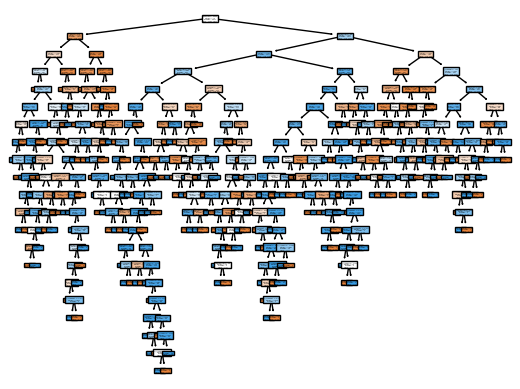

In [ ]:
arbol.fit(X_train_n, y_train_n)
tree.plot_tree(arbol, feature_names = data_set.columns, filled = True)
plt.show()

Podemos notar que el árbol anterior está claramente sobreajustado debido a su profundidad, lo que lo hace no interpretable y probablemente subóptimo en términos de desempeño predictivo.

Para evitar este problema, definiremos diferentes criterios de poda para obtener un árbol más pequeño y fácil de interpretar. Evaluaremos el modelo con los diferentes parámetros de poda utilizando validación cruzada. Con este procedimiento reducimos el riesgo de sobreajuste.

*   max_leaf_nodes: Número máximo de nodos "hoja" en el modelo (nodos terminales).
*   max_depth: Profundidad máxima del arbol.

Se pueden encontrar más parametros para este modelo en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) del clasificador de arboles de decisión.

In [ ]:
max_leaf_nodes = [5,10,15]
max_depth = [3,4,5]
parametros = dict(tree__max_leaf_nodes = max_leaf_nodes,
             tree__max_depth=max_depth)
model_tree = Pipeline(steps=[
        ('sampling', SMOTE()),
        ('tree', DecisionTreeClassifier(criterion = 'gini'))
    ])
tree_cv=GridSearchCV(model_tree,parametros,cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__max_depth': [3, 4, 5],
                         'tree__max_leaf_nodes': [5, 10, 15]})

Vemos cuáles son los mejores parámetros según la grilla:

In [ ]:
print('Best params:')
print(tree_cv.best_params_)

Best params:
{'tree__max_depth': 5, 'tree__max_leaf_nodes': 15}


Graficamos nuestro nuevo árbol:

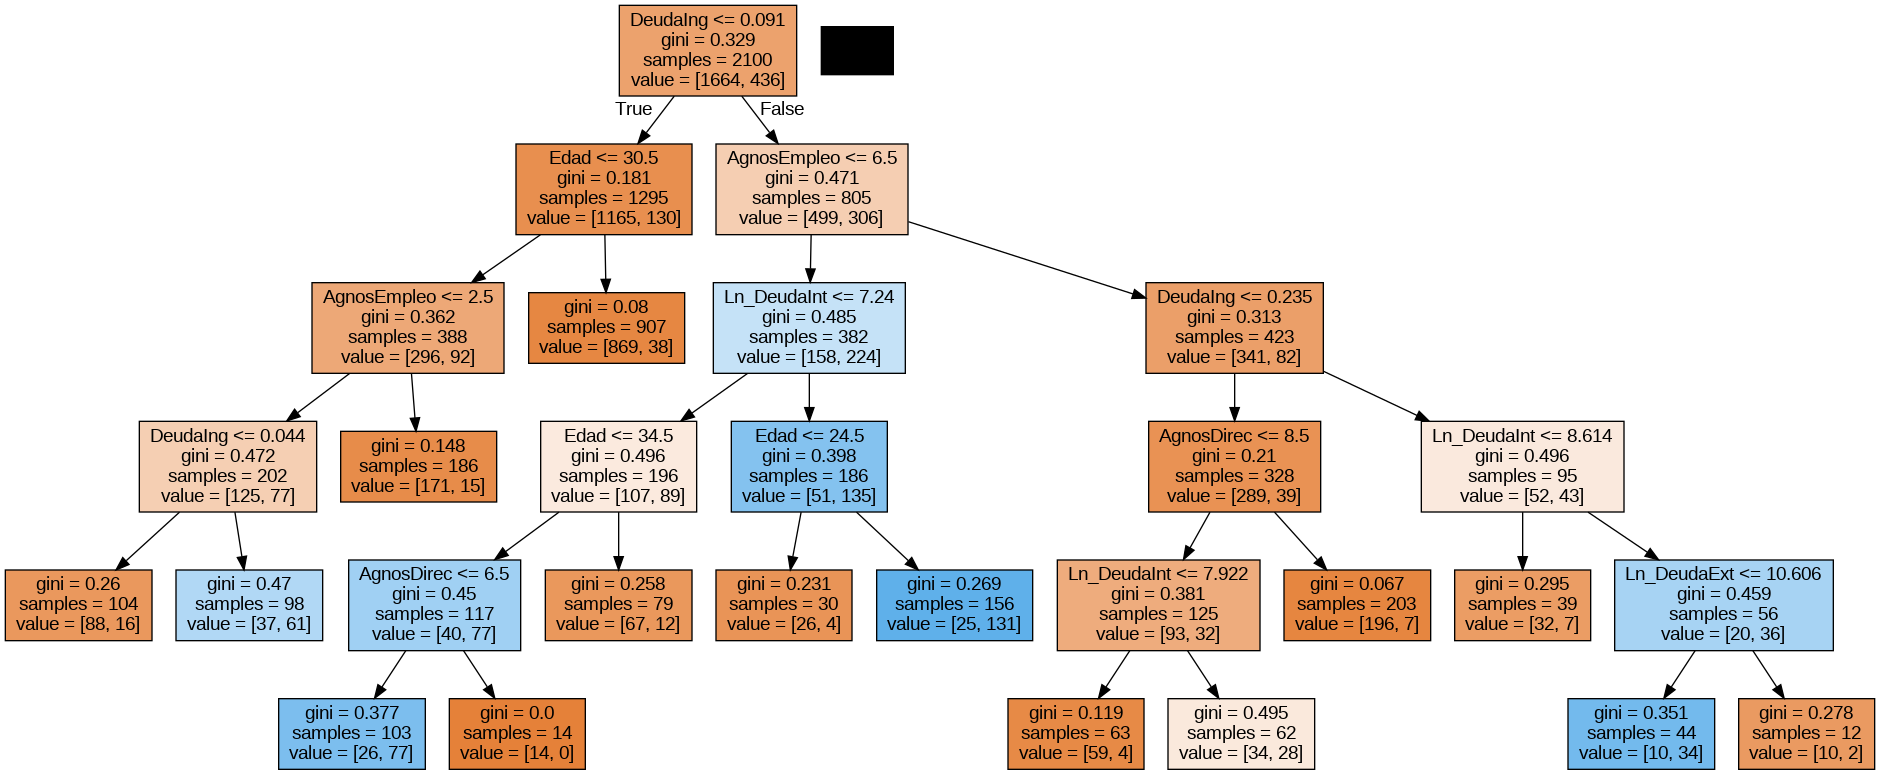

In [ ]:
arbol = DecisionTreeClassifier(criterion = 'gini',max_depth=5, max_leaf_nodes= 15)
arbol.fit(X_train, y_train)
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, feature_names=data_set.columns,filled= True )
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Finalmente, guardamos el mejor modelo de la grilla para luego obtener sus resultados de predicción:

In [ ]:
arbol = tree_cv.best_estimator_

**Los modelos estudiados a continuación requieren que los datos se encuentren escalados entre 0 y 1, por lo que normalizaremos la base de datos**

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit(data_set)
data_set_scaled = pd.DataFrame(scaler_data.transform(data_set), index=data_set.index, columns=data_set.columns)

Dividimos nuevamente los datos:

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_set_scaled, y, test_size=0.3, random_state = 0)

##K-vecinos mas cercanos

Definimos el metodo de clasificación a utilizar:


In [ ]:
Knn = KNeighborsClassifier()

Definimos los parámetros para la grilla:

*   n_neighbors: Número de vecinos.
*   metric: Métrica de distancia que se utiliza para el árbol (Euclideana o Manhattan).

Se pueden encontrar más parámetros para este modelo en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).




Best params for k-neighborns:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3}


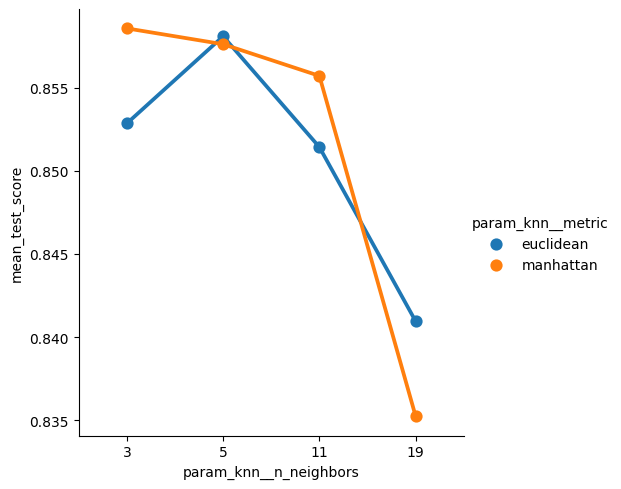

In [ ]:
n_neighbors= [3,5,11,19]
metric = ['euclidean','manhattan']
parametros= dict(knn__n_neighbors= n_neighbors,
                 knn__metric= metric)
model_knn = Pipeline(steps=[
        ('sampling', SMOTE()),
        ('knn', Knn)
    ])
knn_cv=GridSearchCV(model_knn,parametros,cv=10)
knn_cv.fit(X_train_scaled, y_train_scaled)
#Vemos los mejores parámetros según la grilla
print('Best params for k-neighborns:')
print(knn_cv.best_params_)
#Guardamos el mejor modelo para luego obtener sus resultados de validacion
Knn = knn_cv.best_estimator_
#Graficamos los puntaje obtenidos segun cada parámetro analizado
grid_results = pd.DataFrame(knn_cv.cv_results_)
sn.catplot(x="param_knn__n_neighbors", y="mean_test_score", kind="point",  hue="param_knn__metric",data=grid_results)

##Random forest

Los parámetros a analizar para *random forest* son los siguientes:
*   n_estimators: Cantidad de árboles a realizar. Lo dejamos fijo en 100.
*   max_features: Cantidad de variables que se deben considerar al buscar la mejor división.
*   max_depth: Profundidad máxima del arbol.
*   criterion: Función para medir la calidad de la división de cada árbol. Los dos criterios admitidos son la impureza de Gini (gini) y la entropia (entropy).

Se pueden encontrar más parámetros para este modelo en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Best params for Random Forest:
{'rf__criterion': 'entropy', 'rf__max_depth': 6, 'rf__max_features': 6}


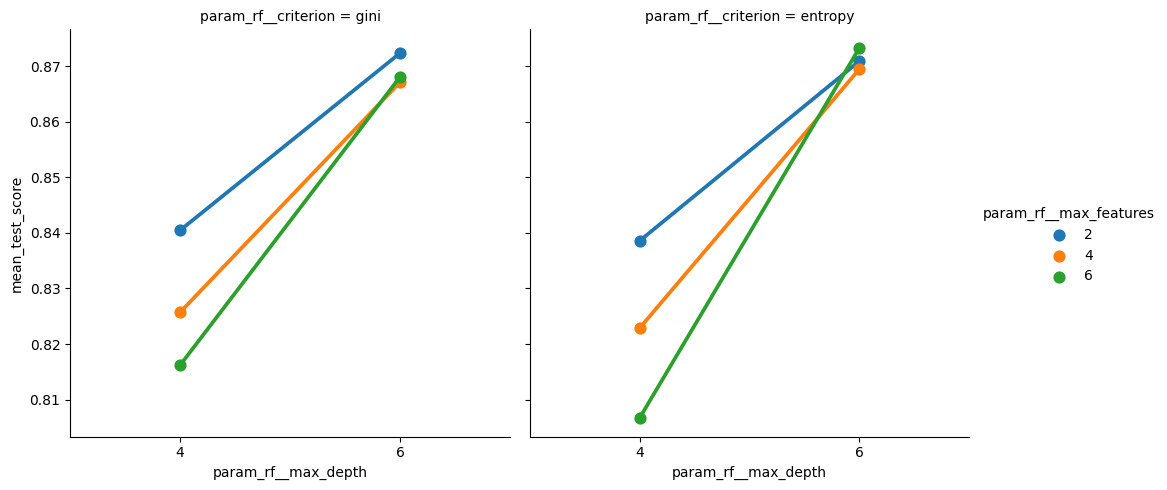

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
#Determinamos los parametros a probar en la grilla
max_features= [2, 4, 6]
max_depth = [4,6]
criterion = ['gini', 'entropy']
parametros=  dict(rf__max_features= max_features,
                  rf__max_depth = max_depth,
                  rf__criterion = criterion)
#Realizamos la grilla
model_rf = Pipeline(steps=[
        ('sampling', SMOTE()),
        ('rf', rf)
    ])
rf_cv=GridSearchCV(model_rf,parametros,cv=10)
rf_cv.fit(X_train_scaled, y_train_scaled)
#Vemos los mejores parámetros según la grilla
print('Best params for Random Forest:')
print(rf_cv.best_params_)
#Guardamos el mejor modelo para luego obtener sus resultados de validacion
rf = rf_cv.best_estimator_
#Graficamos los puntaje obtenidos segun cada parámetro analizado
grid_results = pd.DataFrame(rf_cv.cv_results_)
sn.catplot(x="param_rf__max_depth", y="mean_test_score", hue="param_rf__max_features", kind="point", col="param_rf__criterion",data=grid_results);

# Evaluación


Evaluaremos el rendimiento de los modelos previamente entrenados para determinar su capacidad de predicción. Para esto utilizamos los datos de testeo.

Primero creamos un *dataframe* vacío para ir guardando los resultados de predicción de cada modelo:

In [ ]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

## Regresión logística

Calculamos el *accuracy* del modelo con los datos de testeo:

In [ ]:
Ac_reg = regresion.score(X_test, y_test)
print('Acierto Regresión Logística: {:.2f}'.format(Ac_reg))

Acierto Regresión Logística: 0.84


Calculamos la matriz de confusión del modelo:

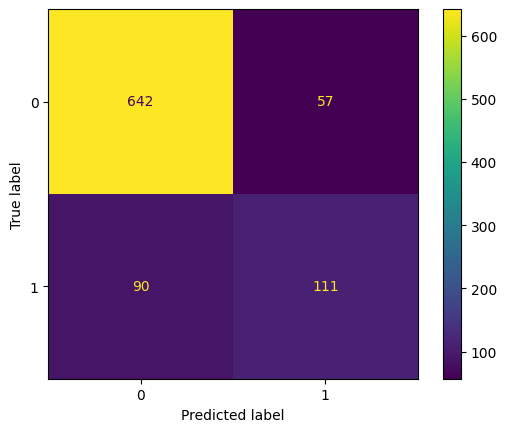

In [ ]:
Y_pred_regresion = regresion.predict(X_test)
cm = confusion_matrix(y_test, Y_pred_regresion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Calculamos el area bajo la curva ROC:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, regresion.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, Y_pred_regresion)
print('AUC: %.3f' % auc)

AUC: 0.735


Agregamos los resultados obtenidos para luego graficar la curvas ROC del modelo:

In [ ]:
result_table = result_table.append({'classifiers': 'Regresión logística','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

**Realizamos el mismo procedimiento con todos los modelos como se muestra a continuación:**

## Arbol de decisión

Acierto árbol de decisión: 0.80
AUC: 0.776


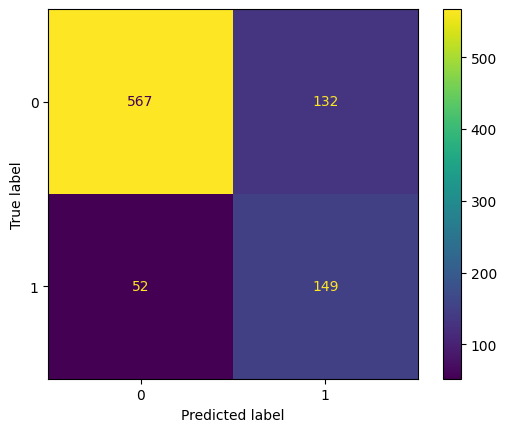

In [ ]:
# Accuracy
Ac_tree = arbol.score(X_test, y_test) #con el modelo entrenado en entrenamiento (arbol)
print('Acierto árbol de decisión: {:.2f}'.format(Ac_tree))
Y_pred_tree = arbol.predict(X_test)
#matriz de confusión
cm = confusion_matrix(y_test, Y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# Cálculo de AUC
fpr, tpr, thresholds = roc_curve(y_test, arbol.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, Y_pred_tree)
print('AUC: %.3f' % auc)
#Agregar a la tabla de resultados
result_table = result_table.append({'classifiers': 'Árbol de decisión','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## K-vecinos mas cercanos

Acierto of k-vecinos más cercanos: 0.85
AUC: 0.839


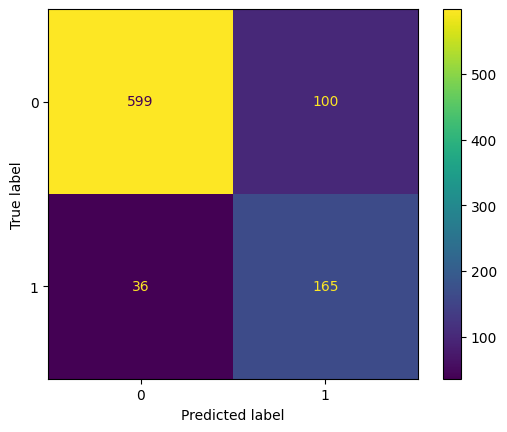

In [ ]:
# Accuracy
Ac_knn = Knn.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Acierto of k-vecinos más cercanos: {:.2f}'.format(Ac_knn))
Y_pred_knn = Knn.predict(X_test_scaled)
#matriz de confusion
cm = confusion_matrix(y_test, Y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# Cálculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, Knn.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_knn)
print('AUC: %.3f' % auc)
#Agregar a la tabla de reusultados
result_table = result_table.append({'classifiers': 'K-vecinos más cercanos','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## Random Forest

Acierto de random forest: 0.86
AUC: 0.858


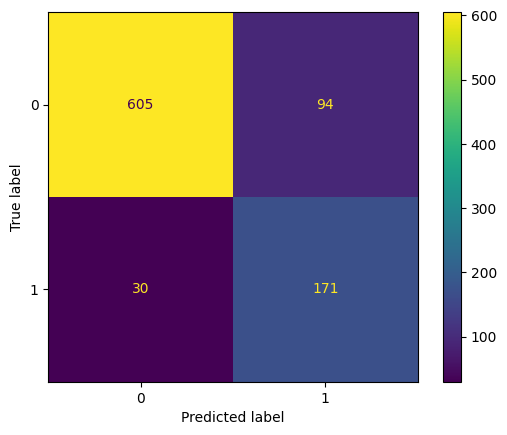

In [ ]:
# Accuracy
Ac_rf = rf.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Acierto de random forest: {:.2f}'.format(Ac_rf))
Y_pred_rf = rf.predict(X_test_scaled)
#matriz de confusion
cm = confusion_matrix(y_test, Y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, rf.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_rf)
print('AUC: %.3f' % auc)
#Agregar a la tabla de resultados
result_table = result_table.append({'classifiers': 'Random forest','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## Curvas ROC


Graficamos las curvas ROC de todos los modelos:

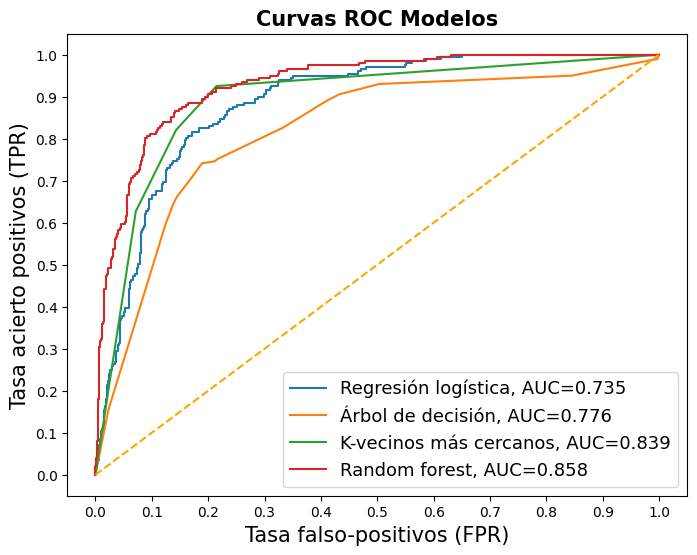

In [ ]:
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Tasa falso-positivos (FPR)", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Tasa acierto positivos (TPR)", fontsize=15)
plt.title('Curvas ROC Modelos', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

Como vemos, en los resultados obtenidos en la evaluación de los modelos, el con mejores resultados es random forest (RF). Guardamos este modelo entrenado en un archivo para luego realizar predicciones con él.

In [ ]:
%cd /content
drive.mount('/content/gdrive',force_remount=True )
dump(rf, 'gdrive/My Drive/Colab Notebooks/modelo_entrenado_RF.joblib')

/content
Mounted at /content/gdrive


['gdrive/My Drive/Colab Notebooks/modelo_entrenado_RF.joblib']